<a href="https://colab.research.google.com/github/KumundzhievMaxim/Spell-SimCLR/blob/main/SimCLR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install efficientnet_pytorch pytorch-lightning

     |████████████████████████████████| 563kB 11.2MB/s 
     |████████████████████████████████| 92kB 7.0MB/s 
     |████████████████████████████████| 829kB 21.5MB/s 
     |████████████████████████████████| 276kB 53.3MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp36-none-any.whl size=16031 sha256=8972803f12a09ce7e6084e65d52c9e06b24b3da5779d9a620a9691a5c3d45c96
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=7ba7269008eae42d0748852289de2a3cef0ba41bb01dc7bb770a3bbba29658ab
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44619 sha256=839ddae705228a6842a1650cd9a6a238d1a3e0d8f0324e0128c09d67fa4b8cc7
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735d

### Imports

In [18]:
import random
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import RMSprop
from torch.multiprocessing import cpu_count
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, SequentialSampler
from torch.optim.lr_scheduler import CosineAnnealingLR

from torchvision import transforms
from torchvision.datasets import STL10
import torchvision.transforms.functional as tvf

from efficientnet_pytorch import EfficientNet

import pytorch_lightning as pl

In [3]:
# Define Custom Loss Function 
class ContrastiveLoss(nn.Module):
    def __init__(self, batch_size, temperature=0.5):
        super().__init__()
        self.batch_size = batch_size
        self.register_buffer("temperature", torch.tensor(temperature))
        self.register_buffer("negatives_mask", (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float())
            
    def forward(self, emb_i, emb_j):
        """
        emb_i and emb_j are batches of embeddings, where corresponding indices are pairs
        z_i, z_j as per SimCLR paper
        """
        z_i = F.normalize(emb_i, dim=1)
        z_j = F.normalize(emb_j, dim=1)

        representations = torch.cat([z_i, z_j], dim=0)
        similarity_matrix = F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)
        
        sim_ij = torch.diag(similarity_matrix, self.batch_size)
        sim_ji = torch.diag(similarity_matrix, -self.batch_size)
        positives = torch.cat([sim_ij, sim_ji], dim=0)
        
        nominator = torch.exp(positives / self.temperature)
        denominator = self.negatives_mask * torch.exp(similarity_matrix / self.temperature)
    
        loss_partial = -torch.log(nominator / torch.sum(denominator, dim=1))
        loss = torch.sum(loss_partial) / (2 * self.batch_size)
        return loss

## Augmentation Utils

In [4]:
class ResizedRotation():
    def __init__(self, angle, output_size=(96, 96)):
        self.angle = angle
        self.output_size = output_size
        
    def angle_to_rad(self, ang): return np.pi * ang / 180.0
        
    def __call__(self, image):
        w, h = image.size
        new_h = int(np.abs(w * np.sin(self.angle_to_rad(90 - self.angle))) + np.abs(h * np.sin(self.angle_to_rad(self.angle))))
        new_w = int(np.abs(h * np.sin(self.angle_to_rad(90 - self.angle))) + np.abs(w * np.sin(self.angle_to_rad(self.angle))))
        img = tvf.resize(image, (new_w, new_h))
        img = tvf.rotate(img, self.angle)
        img = tvf.center_crop(img, self.output_size)
        return img    

class WrapWithRandomParams():
    def __init__(self, constructor, ranges):
        self.constructor = constructor
        self.ranges = ranges
    
    def __call__(self, image):
        randoms = [float(np.random.uniform(low, high)) for _, (low, high) in zip(range(len(self.ranges)), self.ranges)]
        return self.constructor(*randoms)(image)

def random_rotate(image):
    if random.random() > 0.5:
        return tvf.rotate(image, angle=random.choice((0, 90, 180, 270)))
    return image
    
class PretrainingDatasetWrapper(Dataset):
    def __init__(self, ds: Dataset, target_size=(96, 96), debug=False):
        super().__init__()
        self.ds = ds
        self.debug = debug
        self.target_size = target_size
        if debug:
            print("DATASET IN DEBUG MODE")
        
    
        self.preprocess = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        
        random_resized_rotation = WrapWithRandomParams(lambda angle: ResizedRotation(angle, target_size), [(0.0, 360.0)])
        self.randomize = transforms.Compose([
            transforms.RandomResizedCrop(target_size, scale=(1/3, 1.0), ratio=(0.3, 2.0)),
            transforms.RandomChoice([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.Lambda(random_rotate)
            ]),
            transforms.RandomApply([
                random_resized_rotation
            ], p=0.33),
            transforms.RandomApply([
                transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2)
            ], p=0.8),
            transforms.RandomGrayscale(p=0.2)
        ])
    
    def __len__(self): return len(self.ds)
    
    def __getitem_internal__(self, idx, preprocess=True):
        this_image_raw, _ = self.ds[idx]
        
        if self.debug:
            random.seed(idx)
            t1 = self.randomize(this_image_raw)
            random.seed(idx + 1)
            t2 = self.randomize(this_image_raw)
        else:
            t1 = self.randomize(this_image_raw)
            t2 = self.randomize(this_image_raw)
        
        if preprocess:
            t1 = self.preprocess(t1)
            t2 = self.preprocess(t2)
        else:
            t1 = transforms.ToTensor()(t1)
            t2 = transforms.ToTensor()(t2)

        return (t1, t2), torch.tensor(0)

    def __getitem__(self, idx):
        return self.__getitem_internal__(idx, True)
    
    def raw(self, idx):
        return self.__getitem_internal__(idx, False)                

### Download and Unzip data

In [5]:
stl10_unlabeled = STL10(".", split="unlabeled", download=True)

Extracting ./stl10_binary.tar.gz to .


### Apply Augmentations

In [6]:
idx = 123
random_resized_rotation = WrapWithRandomParams(lambda angle: ResizedRotation(angle), [(0.0, 360.0)])

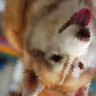

In [7]:
random_resized_rotation(tvf.resize(stl10_unlabeled[idx][0], (96, 96)))

In [8]:
dataset = PretrainingDatasetWrapper(stl10_unlabeled, debug=False)

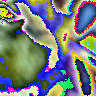

In [9]:
tvf.to_pil_image(dataset[idx][0][0])

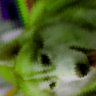

In [10]:
tvf.to_pil_image(dataset.raw(idx)[0][0])

In [11]:
class ImageEmbedding(nn.Module):       
    class Identity(nn.Module):
        def __init__(self): super().__init__()

        def forward(self, x):
            return x
         
    def __init__(self, embedding_size=1024):
        super().__init__()
        
        base_model = EfficientNet.from_pretrained("efficientnet-b0")
        internal_embedding_size = base_model._fc.in_features
        base_model._fc = ImageEmbedding.Identity()
        
        self.embedding = base_model
        
        self.projection = nn.Sequential(
            nn.Linear(in_features=internal_embedding_size, out_features=embedding_size),
            nn.ReLU(),
            nn.Linear(in_features=embedding_size, out_features=embedding_size)
        )

    def calculate_embedding(self, image):
        return self.embedding(image)

    def forward(self, X):
        image = X
        embedding = self.calculate_embedding(image)
        projection = self.projection(embedding)
        return embedding, projection


class ImageEmbeddingModule(pl.LightningModule):
    def __init__(self, hparams):
        hparams = Namespace(**hparams) if isinstance(hparams, dict) else hparams
        super().__init__()
        self.hparams = hparams
        self.model = ImageEmbedding()
        self.loss = ContrastiveLoss(hparams.batch_size)
    
    def total_steps(self):
        return len(self.train_dataloader()) // self.hparams.epochs
    
    def train_dataloader(self):
        return DataLoader(PretrainingDatasetWrapper(stl10_unlabeled, 
                                                    debug=getattr(self.hparams, "debug", False)),
                          batch_size=self.hparams.batch_size, 
                          num_workers=cpu_count(),
                          sampler=SubsetRandomSampler(list(range(hparams.train_size))),
                          drop_last=True)
    
    def val_dataloader(self):
        return DataLoader(PretrainingDatasetWrapper(stl10_unlabeled,
                                                    debug=getattr(self.hparams, "debug", False)),
                          batch_size=self.hparams.batch_size, 
                          shuffle=False,
                          num_workers=cpu_count(),
                          sampler=SequentialSampler(list(range(hparams.train_size + 1, hparams.train_size + hparams.validation_size))),
                          drop_last=True)
    
    def forward(self, X):
        return self.model(X)
    
    def step(self, batch, step_name = "train"):
        (X, Y), y = batch
        embX, projectionX = self.forward(X)
        embY, projectionY = self.forward(Y)
        loss = self.loss(projectionX, projectionY)
        loss_key = f"{step_name}_loss"
        tensorboard_logs = {loss_key: loss}

        return { ("loss" if step_name == "train" else loss_key): loss, 'log': tensorboard_logs,
                        "progress_bar": {loss_key: loss}}
    
    def training_step(self, batch, batch_idx):
        return self.step(batch, "train")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, "val")
    
    def validation_end(self, outputs):
        if len(outputs) == 0:
            return {"val_loss": torch.tensor(0)}
        else:
            loss = torch.stack([x["val_loss"] for x in outputs]).mean()
            return {"val_loss": loss, "log": {"val_loss": loss}}

    def configure_optimizers(self):
        optimizer = RMSprop(self.model.parameters(), lr=self.hparams.lr)
        return [optimizer], []

### Net Hparams 

In [12]:
from argparse import Namespace
hparams = Namespace(
    lr=1e-3,
    epochs=50,
    batch_size=160,
    train_size=10000,
    validation_size=1000
)

In [13]:
module = ImageEmbeddingModule(hparams)
trainer = pl.Trainer(gpus=1, max_epochs=hparams.epochs)

trainer.fit(module)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Loaded pretrained weights for efficientnet-b0



  | Name  | Type            | Params
------------------------------------------
0 | model | ImageEmbedding  | 6 M   
1 | loss  | ContrastiveLoss | 0     


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The {log:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.

# log on a step or aggregate epoch metric to the logger and/or progress bar
# (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The {progress_bar:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.

# log on a step or aggregate epoch metric to the logger and/or progress bar
# (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)


1

In [15]:
checkpoint_file = "efficientnet-b0-stl10-embeddings.ckpt"
trainer.save_checkpoint(checkpoint_file)

In [16]:
class SimCLRClassifier(nn.Module):
    def __init__(self, n_classes, freeze_base, embeddings_model_path, hidden_size=512):
        super().__init__()
        
        base_model = ImageEmbeddingModule.load_from_checkpoint(embeddings_model_path).model
        
        self.embeddings = base_model.embedding
        
        if freeze_base:
            print("Freezing embeddings")
            for param in self.embeddings.parameters():
                param.requires_grad = False
                
        # Only linear projection on top of the embeddings should be enough
        self.classifier = nn.Linear(in_features=base_model.projection[0].in_features, 
                      out_features=n_classes if n_classes > 2 else 1)

    
    def forward(self, X, *args):
        emb = self.embeddings(X)
        return self.classifier(emb)

class SimCLRClassifierModule(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        hparams = Namespace(**hparams) if isinstance(hparams, dict) else hparams
        self.hparams = hparams
        self.model = SimCLRClassifier(hparams.n_classes, hparams.freeze_base, 
                                      hparams.embeddings_path,
                                      self.hparams.hidden_size)
        self.loss = nn.CrossEntropyLoss()
    
    def total_steps(self):
        return len(self.train_dataloader()) // self.hparams.epochs
    
    def preprocessing(seff):
        return transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    
    def get_dataloader(self, split):
        return DataLoader(STL10(".", split=split, transform=self.preprocessing()),
                          batch_size=self.hparams.batch_size, 
                          shuffle=split=="train",
                          num_workers=cpu_count(),
                         drop_last=False)
    
    def train_dataloader(self):
        return self.get_dataloader("train")
    
    def val_dataloader(self):
        return self.get_dataloader("test")
    
    def forward(self, X):
        return self.model(X)
    
    def step(self, batch, step_name = "train"):
        X, y = batch
        y_out = self.forward(X)
        loss = self.loss(y_out, y)
        loss_key = f"{step_name}_loss"
        tensorboard_logs = {loss_key: loss}

        return { ("loss" if step_name == "train" else loss_key): loss, 'log': tensorboard_logs,
                        "progress_bar": {loss_key: loss}}
    
    def training_step(self, batch, batch_idx):
        return self.step(batch, "train")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, "val")
    
    def test_step(self, batch, batch_idx):
        return self.step(Batch, "test")
    
    def validation_end(self, outputs):
        if len(outputs) == 0:
            return {"val_loss": torch.tensor(0)}
        else:
            loss = torch.stack([x["val_loss"] for x in outputs]).mean()
            return {"val_loss": loss, "log": {"val_loss": loss}}

    def configure_optimizers(self):
        optimizer = RMSprop(self.model.parameters(), lr=self.hparams.lr)
        schedulers = [
            CosineAnnealingLR(optimizer, self.hparams.epochs)
        ] if self.hparams.epochs > 1 else []
        return [optimizer], schedulers        

In [19]:
hparams_cls = Namespace(
    lr=1e-3,
    epochs=5,
    batch_size=160,
    n_classes=10,
    freeze_base=True,
    embeddings_path="./efficientnet-b0-stl10-embeddings.ckpt",
    hidden_size=512
)
module = SimCLRClassifierModule(hparams_cls)
trainer = pl.Trainer(gpus=1, max_epochs=hparams_cls.epochs)
trainer.fit(module)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | SimCLRClassifier | 4 M   
1 | loss  | CrossEntropyLoss | 0     


Loaded pretrained weights for efficientnet-b0
Freezing embeddings


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The {log:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.

# log on a step or aggregate epoch metric to the logger and/or progress bar
# (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The {progress_bar:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.

# log on a step or aggregate epoch metric to the logger and/or progress bar
# (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)


1

In [ ]:
def evaluate(data_loader, module):
    with torch.no_grad():
        progress = ["/", "-", "\\", "|", "/", "-", "\\", "|"]
        module.eval().cuda()
        true_y, pred_y = [], []
        for i, batch_ in enumerate(data_loader):
            X, y = batch_
            print(progress[i % len(progress)], end="\r")
            y_pred = torch.argmax(module(X.cuda()), dim=1)
            true_y.extend(y.cpu())
            pred_y.extend(y_pred.cpu())
        print(classification_report(true_y, pred_y, digits=3))
        return true_y, pred_y

In [ ]:
_ = evaluate(module.val_dataloader(), module)